# Retirement Planner

---

## Environment Setup

In [28]:
# Import libraries and dependencies

import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline


In [29]:
# Set the random seed for resutls reproducibility (for testing purposes only)

np.random.seed(42)


---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [30]:
# Load .env enviroment variables

from dotenv import load_dotenv
load_dotenv("/Users/heenaroy/Desktop/.env")

# Set Alpaca API key and secret

alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")


# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [31]:
# Subset your tickers, then pull returns data:

# Set the ticker

ticker = ["SPY", "AGG"]

# Set timeframe to '1D'

timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.

start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG

df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns

df = df.drop(columns=['open', 'high', 'low', 'volume'], level=1)


In [32]:
# Display sample data

df.head()


AGG     SPY
                             close   close
2019-01-02 00:00:00-05:00  106.585  249.89
2019-01-03 00:00:00-05:00  107.020  244.46
2019-01-04 00:00:00-05:00  106.695  252.41
2019-01-07 00:00:00-05:00  106.470  254.40
2019-01-08 00:00:00-05:00  106.420  256.65

---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [33]:
# Clean up data

# Drop Outer Table Level
    
df = df.droplevel(axis=1, level=0)

# Rename close to Stock Ticker

df.columns = ["AGG", "SPY"]

# Since this is daily data, keep only the date (remove the time)

df.index = df.index.date

# Display sample data

df.head()


AGG     SPY
2019-01-02  106.585  249.89
2019-01-03  107.020  244.46
2019-01-04  106.695  252.41
2019-01-07  106.470  254.40
2019-01-08  106.420  256.65

In [34]:
# Calculate the daily roi for the stocks

daily_roi = df.pct_change()

# Display sample data

daily_roi.head()


AGG       SPY
2019-01-02       NaN       NaN
2019-01-03  0.004081 -0.021730
2019-01-04 -0.003037  0.032521
2019-01-07 -0.002109  0.007884
2019-01-08 -0.000470  0.008844

In [35]:
# Compute daily volatility

# Value of Average Daily ROI

avg_daily_roi_agg = daily_roi.mean()["AGG"]
avg_daily_roi_spy = daily_roi.mean()["SPY"]

# Value of Standard Deviation of Daily ROI

std_daily_roi_agg = daily_roi.std()["AGG"]
std_daily_roi_spy = daily_roi.std()["SPY"]


In [36]:
# Save the last day's closing price

agg_last_price = df["AGG"][-1]
spy_last_price = df["SPY"][-1]


In [37]:
# Setup the Monte Carlo Parameters for 500 simulations over 30 years of records

number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()
simulated_price_df = pd.DataFrame()


In [38]:
# Run the Monte Carlo Simulation

for simulation in range(number_simulations):

    # Initialize the simulated prices list with the last closing price of AGG & SPY
    
    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]
    
    # Simulate the returns for 252 days of 30 years
    
    for i in range (number_records):
        
        # Calculate the simulated price using the last price within the list
        
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_roi_agg, std_daily_roi_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_roi_spy, std_daily_roi_spy))    
        
        # Append the simulated prices to the list
        
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    # Append the simulated prices of each simulation to the DataFrame
    
    simulated_price_df["AGG Prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY Prices"] = pd.Series(simulated_spy_prices)
    
    # Calculate the Daily ROI of simulated prices
    
    simulated_daily_roi = simulated_price_df.pct_change()
    
    # Set portfolio weights to 40% AGG & 60% SPY
    
    weights = [0.40, 0.60]
    
    # Update Daily ROI based on Weighted Portfolio Mix 
    
    portfolio_daily_roi = simulated_daily_roi.dot(weights)
    
    # Calculate Simulated, Normalized Cumulative Returns
    
    monte_carlo[simulation] = (1 + portfolio_daily_roi.fillna(0)).cumprod()


In [39]:
# Check that the simulation ran successfully

monte_carlo.head()


0         1         2         3         4         5         6    \
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1  1.000476  1.000536  0.998808  1.005394  1.011797  0.994452  0.997251   
2  1.008876  1.004699  1.003590  0.996711  1.009571  0.994247  0.994214   
3  1.008286  1.004228  1.003770  0.998232  1.007751  0.987669  0.998229   
4  1.013963  1.006575  1.008493  1.002636  1.013664  0.990972  1.003241   

        7         8         9    ...       490       491       492       493  \
0  1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  1.000000   
1  1.013277  1.000869  0.995376  ...  1.002066  0.992709  1.001801  1.002671   
2  1.007199  1.000225  0.993036  ...  1.005759  0.994517  1.003317  1.006181   
3  1.001361  1.000230  1.001279  ...  1.006771  0.988444  1.004118  1.010565   
4  0.995491  1.002048  1.006036  ...  1.004196  0.992123  1.004724  1.004423   

        494       495       496       497       498       499  
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1  0.996472  1.003160  1.001638  1.006800  0.998173  0.994765  
2  0.997472  0.991774  1.002764  1.005408  0.996137  0.998871  
3  0.993293  0.994454  1.008272  0.999144  0.998656  1.003328  
4  0.994844  0.993782  1.005722  1.002248  0.996964  1.004095  

[5 rows x 500 columns]

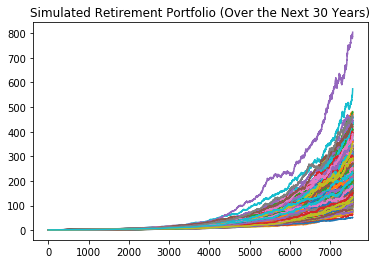

In [42]:
# Visualize the Simulation

monte_carlo.plot(legend=None, title="Simulated Retirement Portfolio (Over the Next 30 Years)")


In [43]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)

ending_monte_carlo = monte_carlo.iloc[-1, :]

ending_monte_carlo.head()


0    192.773859
1    171.964137
2    177.998514
3    138.466715
4    175.628015
Name: 7560, dtype: float64

0    192.773859
1    171.964137
2    177.998514
3    138.466715
4    175.628015
Name: 7560, dtype: float64

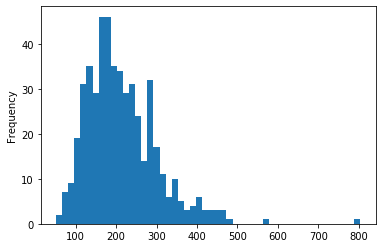

In [44]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)

ending_monte_carlo.plot(kind="hist", bins=50)
ending_monte_carlo.value_counts(bins=50) / len(ending_monte_carlo)
ending_monte_carlo.head()


In [45]:
# Display the 90% confidence interval for the ending returns

confidence_interval = ending_monte_carlo.quantile(q=[0.05, 0.95])
confidence_interval


0.05    102.825606
0.95    379.341808
Name: 7560, dtype: float64

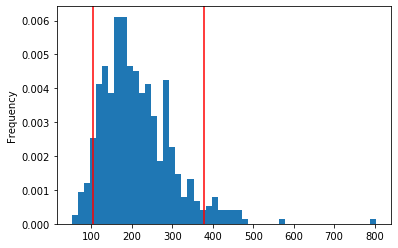

In [46]:
# Visualize the distribution of the ending returns

plt.figure();
ending_monte_carlo.plot(kind="hist", density=True, bins=50)
plt.axvline(confidence_interval.iloc[0], color="r")
plt.axvline(confidence_interval.iloc[1], color="r")
plt.savefig('Monte_Carlo_Bar.png')


---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [47]:
# Compute cumulative returns

expected_cumulative_roi = ending_monte_carlo.quantile(q=[0.10, 0.50, 0.90])
expected_cumulative_roi


0.1    119.027485
0.5    199.083857
0.9    320.561549
Name: 7560, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [49]:
# Set initial investment

initial_investment = 20000

# Compute expected portfolio return

investment_pnl_10p = round(initial_investment + (initial_investment * expected_cumulative_roi.iloc[0]),2)
investment_pnl_50p = round(initial_investment + (initial_investment * expected_cumulative_roi.iloc[1]),2)
investment_pnl_90p = round(initial_investment + (initial_investment * expected_cumulative_roi.iloc[2]),2)

print("")
print(f"Based on an investment of ${initial_investment}, you will have total retirement income of ${investment_pnl_10p} at the low range, ${investment_pnl_50p} at the mid range, ${investment_pnl_90p} at the high range.")
print("")



Based on an investment of $20000, you will have total retirement income of $2400549.7 at the low range, $4001677.14 at the mid range, $6431230.97 at the high range.



### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [50]:
# Set Plaid's projected income

projected_income = 7389

# Calculate the 4% withdrawal for the ending return as retirement income

withdrawal_rate = .04
withdrawal = round(withdrawal_rate * investment_pnl_10p, 2)

# Determine if the retirement income meets or exceeds the current projected income

if withdrawal >= projected_income:
    print("")
    print(f"You should have ${withdrawal} in annual retirement income which exceeds your current annual income of ${projected_income}")
    print("")
else:
    print("")
    print(f"You should have ${withdrawal} in annual retirement income which is less than your current annual income of ${projected_income}")
    print("")



You should have $96021.99 in annual retirement income which exceeds your current annual income of $7389



### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [51]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount

pct_incr = 0.50

# Set initial investment

new_initial_investment = initial_investment * (1 + pct_incr)

# Compute expected portfolio return

investment_pnl_10p2 = round(new_initial_investment + (new_initial_investment * expected_cumulative_roi.iloc[0]),2)
investment_pnl_50p2 = round(new_initial_investment + (new_initial_investment * expected_cumulative_roi.iloc[1]),2)
investment_pnl_90p2 = round(new_initial_investment + (new_initial_investment * expected_cumulative_roi.iloc[2]),2)

print("")
print(f"In 30 years, with an investment of ${new_initial_investment}, you should have total retirement income of ${investment_pnl_10p2} at the low range, ${investment_pnl_50p2} at the mid range, ${investment_pnl_90p2} at the high range.")
print("")



In 30 years, with an investment of $30000.0, you should have total retirement income of $3600824.55 at the low range, $6002515.72 at the mid range, $9646846.46 at the high range.



### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [52]:
# Compute projected returns

new_monte_carlo = monte_carlo.quantile([0.05, 0.50, 0.95], axis="columns").pivot_table(columns=["0.05", "0.50", "0.95"])

# Display sample data

new_monte_carlo.head()
    

0.05      0.50      0.95
0  1.000000  1.000000  1.000000
1  0.992691  1.000785  1.008573
2  0.990438  1.001287  1.013288
3  0.989383  1.002328  1.015727
4  0.988241  1.002972  1.018309

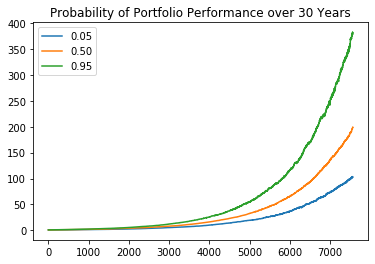

In [57]:
# Plot the cumulative returns over time

new_monte_carlo.plot(title="Probability of Portfolio Performance over 30 Years")


### Optional Challenge — Early Retirement

Harold was really impressed with your work on this planner, but commented that 30 years seems like such a long time to wait to retire! Harold starts wondering if the retirement plan could be adjusted to retire earlier than normal. Try adjusting the portfolio to either include more risk (a higher stock than bond ratio) or to have a larger initial investment and rerun the retirement analysis to see what it would take to retire in 5 years instead of 30!


In 5 years, given an investment of $60000, you should have total retirement income of $187627.15 at the low range, $222827.02 at the mid range, $277244.05 at the high range.


You should have $7505.09 in annual retirement income which exceeds your current annual income of $7389



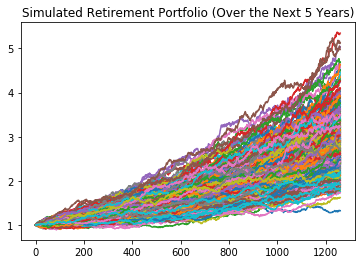

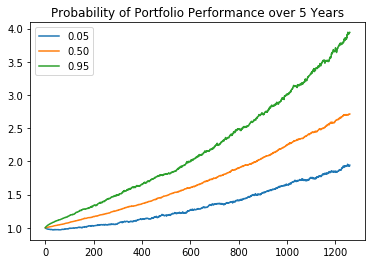

In [58]:
# Setup the Monte Carlo Parameters for 500 simulations over 5 years of records

number_simulations2 = 500
number_records2 = 252 * 5
monte_carlo2 = pd.DataFrame()
simulated_price_df2 = pd.DataFrame()

# Run the Monte Carlo Simulation

for simulation2 in range(number_simulations2):

    # Initialize the simulated prices list with the last closing price of AGG & SPY
    
    simulated_agg_prices2 = [agg_last_price]
    simulated_spy_prices2 = [spy_last_price]
    
    # Simulate the returns for 252 days of 5 years
    
    for i2 in range (number_records2):
        
        # Calculate the simulated price using the last price within the list
        
        simulated_agg_price2 = simulated_agg_prices2[-1] * (1 + np.random.normal(avg_daily_roi_agg, std_daily_roi_agg))
        simulated_spy_price2 = simulated_spy_prices2[-1] * (1 + np.random.normal(avg_daily_roi_spy, std_daily_roi_spy))    
        
        # Append the simulated prices to the list
        
        simulated_agg_prices2.append(simulated_agg_price2)
        simulated_spy_prices2.append(simulated_spy_price2)
    
    # Append the simulated prices of each simulation to the DataFrame
    
    simulated_price_df2["AGG Prices"] = pd.Series(simulated_agg_prices2)
    simulated_price_df2["SPY Prices"] = pd.Series(simulated_spy_prices2)
    
    # Calculate the Daily ROI of simulated prices
    
    simulated_daily_roi2 = simulated_price_df2.pct_change()
    
    # Set portfolio weights to 40% AGG & 60% SPY
    
    weights2 = [0.25, 0.75]
    
    # Update Daily ROI based on Weighted Portfolio Mix 
    
    portfolio_daily_roi2 = simulated_daily_roi2.dot(weights2)
    
    # Calculate Simulated, Normalized Cumulative Returns
    
    monte_carlo2[simulation2] = (1 + portfolio_daily_roi2.fillna(0)).cumprod()
    

# Visualize the Simulation

monte_carlo2.plot(legend=None, title="Simulated Retirement Portfolio (Over the Next 5 Years)")
  
    
# Select the last row for the cumulative returns (cumulative returns at 5 years)

ending_monte_carlo2 = monte_carlo2.iloc[-1, :]    

# Compute cumulative returns

expected_cumulative_roi2 = ending_monte_carlo2.quantile(q=[0.10, 0.50, 0.90])

# Set initial investment

initial_investment2 = 60000

# Compute expected portfolio return

investment_pnl_10p2 = round(initial_investment2 + (initial_investment2 * expected_cumulative_roi2.iloc[0]),2)
investment_pnl_50p2 = round(initial_investment2 + (initial_investment2 * expected_cumulative_roi2.iloc[1]),2)
investment_pnl_90p2 = round(initial_investment2 + (initial_investment2 * expected_cumulative_roi2.iloc[2]),2)

print("")
print(f"In 5 years, given an investment of ${initial_investment2}, you should have total retirement income of ${investment_pnl_10p2} at the low range, ${investment_pnl_50p2} at the mid range, ${investment_pnl_90p2} at the high range.")
print("")

# Compute projected returns

new_monte_carlo2 = monte_carlo2.quantile([0.05, 0.50, 0.95], axis="columns").pivot_table(columns=["0.05", "0.50", "0.95"])

# Plot the cumulative returns over time

new_monte_carlo2.plot(title="Probability of Portfolio Performance over 5 Years")

# Set Plaid's projected income

projected_income = 7389

# Calculate the 4% withdrawal for the ending return as retirement income

withdrawal_rate = .04
withdrawal2 = round(withdrawal_rate * investment_pnl_10p2, 2)

# Determine if the retirement income meets or exceeds the current projected income

if withdrawal2 >= projected_income:
    print("")
    print(f"You should have ${withdrawal2} in annual retirement income which exceeds your current annual income of ${projected_income}")
    print("")
else:
    print("")
    print(f"You should have ${withdrawal2} in annual retirement income which is less than your current annual income of ${projected_income}")
    print("")
